In [ ]:

from datetime import datetime

now = datetime.now() # current date and time

print(now.strftime("%m_%d_%Y_%H_%M"))

In [1]:
import os
from tqdm.notebook import tqdm

import torchvision.transforms as transforms
import torch
from torch import optim


from models.old_model import SiameseNetwork
from models.new_model import NewSiameseNetwork
from models import pretrained_model

from losses.euclidean import ContrastiveLoss
from losses.cosine import ContrastiveLossCosine
from losses.triplet import TripletLoss

from utils.vis_utils import example_vis
from utils.other_utils import joinpath, NetworkDataset, TestNetworkDataset, get_dataset

In [2]:
# Setup the path where images are located
PATH = "data/lab_parts"

# # save the model path
# MODEL_PATH = "/home/akshatgarg/Just-In-Time-Detection-of-Unknown-Classes-Using-Deep-Learning/saved_model/all_lab_parts_model"
# if not os.path.exists(MODEL_PATH):
#     os.makedirs(MODEL_PATH)

# Setup the number of channels in the image, 3 for color, 1 for monochrome
nchannel=3

# no of epoch
EPOCH = 10

# whether it is triplet or contrastive
FLAG = 'contrastive'
# FLAG = 'triplet'

# rotation flag
ROTATION = False

# if testing
testing = False

# Threshold score
THRESHOLD_SCORE = 1

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if device.type == "cuda":
    print(torch.cuda.get_device_name())
    torch.cuda.empty_cache()

NVIDIA GeForce RTX 3070 Laptop GPU


In [3]:
# Resize the images and transform to tensors
if ROTATION:
    transformation = transforms.Compose([transforms.Resize((224,224)),
        transforms.ToTensor(), 
        transforms.RandomApply([
            transforms.RandomRotation([-30,30])], p = 0.2)
    ])
else:
    # transformation = transforms.Compose([transforms.Resize((100,100)),
    #                                  transforms.ToTensor()])
    transformation = transforms.Compose([transforms.Resize((224,224)),
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])] 
                                     )

In [4]:
os.cpu_count() #cpu count

16

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


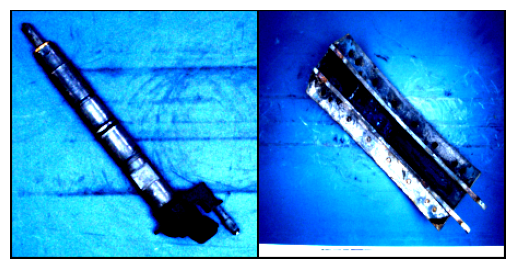

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[1.]


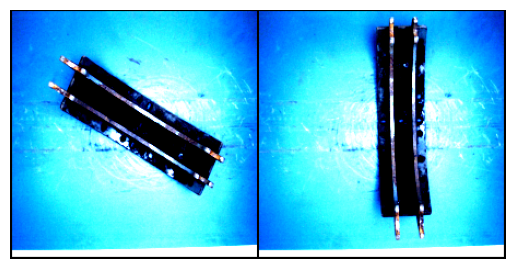

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0.]


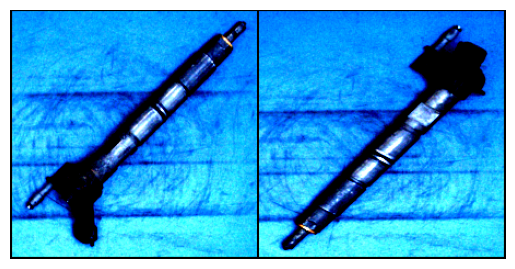

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0.]


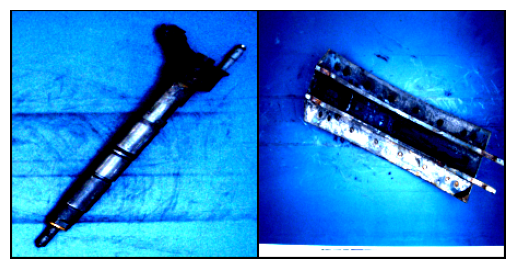

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[1.]


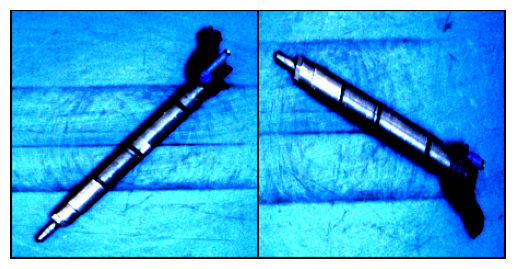

[0.]


In [5]:
vis_dataloader,_ =  get_dataset(joinpath(PATH,'train'), nchannel, transformation,NetworkDataset,FLAG,0,1,True)
example_vis(vis_dataloader,FLAG)

In [6]:
train_dataloader,train_size = get_dataset(joinpath(PATH,'train'), nchannel, transformation,NetworkDataset,FLAG,0,64,True)
valid_dataloader,_ = get_dataset(joinpath(PATH,'valid'), nchannel, transformation,NetworkDataset,FLAG,0,64,True)

In [7]:
len(train_size)

931

In [8]:
net = pretrained_model.SiameseNetwork().to(device)
optimizer = optim.Adam(net.parameters(), lr=0.0005)
if FLAG == 'contrastive':
    criterion = ContrastiveLoss()
elif FLAG == 'triplet':
    criterion = TripletLoss()

/home/akshatgarg/anaconda3/envs/torchcapstone/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/akshatgarg/anaconda3/envs/torchcapstone/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [9]:
# print(net)

In [10]:
def contrastive_train(net,optimizer,criterion,epochs=EPOCH):
    loss_history = []
    valid_loss_history = []
    for epoch in tqdm(range(epochs), desc='Epochs'):
        # Iterate over batches
        # for (img0, img1, label) in train_dataloader:
        for step,((img0, img1, label),(valid_img0,valid_img1,valid_label)) in enumerate(zip(train_dataloader,valid_dataloader),0):

            # Send the images and labels to CUDA
            img0, img1, label = img0.to(device), img1.to(device), label.to(device)
            # print(img0.shape)
            valid_img0, valid_img1, valid_label = valid_img0.to(device), valid_img1.to(device), valid_label.to(device)

            # Zero the gradients
            optimizer.zero_grad()

            # Pass in the two images into the network and obtain two outputs
            output1, output2 = net(img0, img1)
            valid_output1, valid_output2 = net(valid_img0, valid_img1)

            # Pass the outputs of the networks and label into the loss function
            loss_contrastive = criterion(output1, output2, label)
            valid_loss_contrastive = criterion(valid_output1, valid_output2, valid_label)

            # Calculate the backpropagation
            loss_contrastive.backward()

            # Optimize
            optimizer.step()
        # save the loss history for each epoch
        loss_history.append(loss_contrastive.item())
        valid_loss_history.append(valid_loss_contrastive.item())
    return(loss_history,valid_loss_history)

In [11]:
def triplet_train(net,optimizer,criterion,epochs=EPOCH):
    loss_history = []
    for epoch in tqdm(range(EPOCH), desc="Epochs"):
        # Iterate over batches
        for step, (anchor_img, positive_img, negative_img,_,_,_) in enumerate(train_dataloader,0):
            # Send the images and labels to CUDA
            anchor_img, positive_img, negative_img = anchor_img.to(device), positive_img.to(device), negative_img.to(device)
            
            # Zero the gradients
            optimizer.zero_grad()
            
            # Pass in the three images into the network and obtain three outputs
            anchor_out = net.forward_once(anchor_img)
            positive_out = net.forward_once(positive_img)
            negative_out = net.forward_once(negative_img)
            
            # Pass the outputs of the networks and label into the loss function
            loss_triplet = criterion(anchor_out, positive_out, negative_out)

            # Calculate the backpropagation
            loss_triplet.backward()

            # Optimize
            optimizer.step()
        # save the loss history for each epoch
        loss_history.append(loss_triplet.item())
    return loss_history

In [12]:
if FLAG == 'contrastive':
    train_loss, valid_loss= contrastive_train(net, optimizer, criterion)
    # _, train_loss = train()
elif FLAG == 'triplet':
    train_loss = triplet_train(net, optimizer, criterion)
    # Make sure to also calculate valid_loss for the triplet case

Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

In [13]:
import plotly.graph_objects as go

# Create the figure
fig = go.Figure()

# Add traces for train_loss and valid_loss
fig.add_trace(go.Scatter(x=list(range(len(train_loss))), y=train_loss,
                    mode='lines', name='Training Loss', line=dict(color='red')))
fig.add_trace(go.Scatter(x=list(range(len(valid_loss))), y=valid_loss,
                    mode='lines', name='Validation Loss', line=dict(color='blue')))

# Set the title and axis labels
fig.update_layout(title='Loss vs Epochs', xaxis_title='Epoch', yaxis_title='Loss')

# Display the figure
fig.show()


In [14]:
import pickle

# open a file in binary write mode
with open(joinpath(MODEL_PATH,'loss_list.pkl'), 'wb') as f:
    # pickle the two lists
    pickle.dump(train_loss, f)
    pickle.dump(valid_loss, f)


In [15]:
torch.save(net.state_dict(), joinpath(MODEL_PATH,'model.pt'))
